In this demonstraction, I chose bn221103285 to display the pros and cons of TRIGDAT and TTE data. For short, TRIGDAT has smaller size of file and can tell us which detector find the burst, but its pre-binned data is not useful! In comparison, although TTE has larger size of file, it can provide more complete event data.

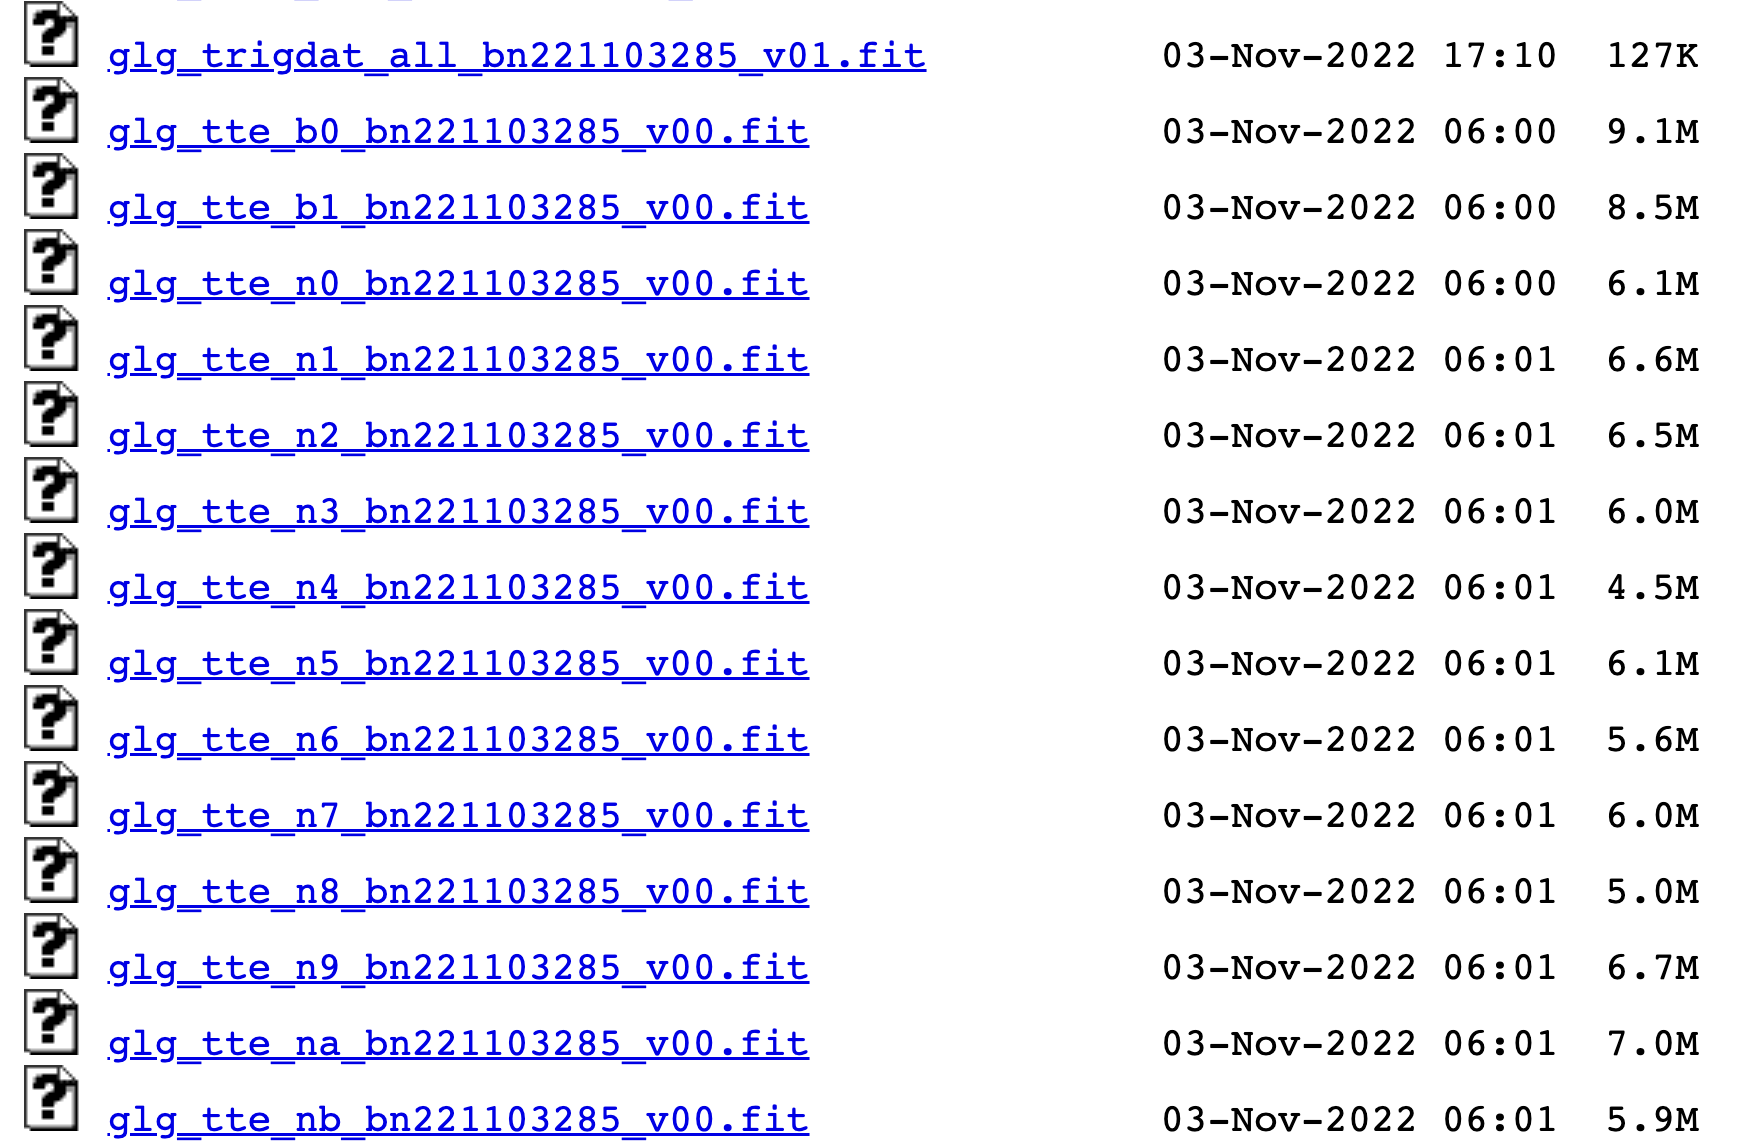

In [1]:
# import useful packages

from gbm.data import Trigdat

from gbm.data import TTE
from gbm.binning.unbinned import bin_by_time

from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial

from gbm.plot import Lightcurve, Spectrum

/Users/jasonpbu/Desktop/Master/#Master_paper/GRB_lightcurve/gbm_py/gbm_data_tools-1.1.1/gbm/plot/lal_post_subs.py:184: UserWarning: Basemap not installed. Some functionality not available.
  warnings.warn('Basemap not installed. Some functionality not available.')


In [2]:
# setup interested energy range in keV
# recommendation is (8.0, 900.0)
erange = (50.0, 300.0)

In [3]:
# open TRIGDAT file
trigdat = Trigdat.open('glg_trigdat_all_bn221103285_v01.fit')

# check which detectors raise the trigger
trig_dets = trigdat.triggered_detectors
print(trig_dets)

['n0', 'n3']


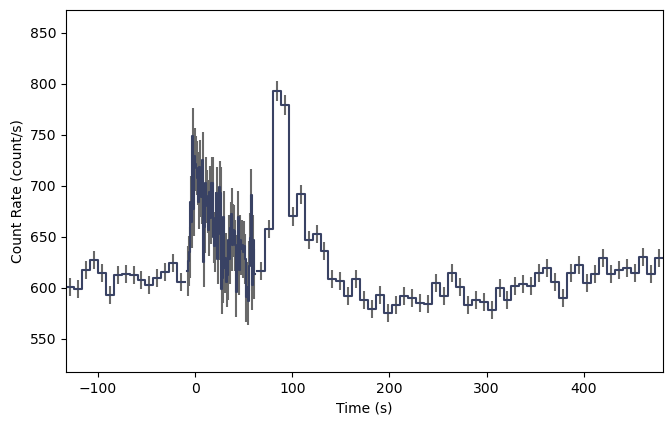

In [4]:
# sum over data in triggered detectors
# possible options for src timescale is 64, 256, or 1024 ms
summed_phaii = trigdat.sum_detectors(trig_dets, timescale=1024)

# convert info. in .fit file into histogram and plot it
lc_data_trigdat = summed_phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data_trigdat)

In [5]:
# open TTE file
tte_1 = TTE.open('glg_tte_n0_bn221103285_v00.fit')
tte_2 = TTE.open('glg_tte_n3_bn221103285_v00.fit')

# combine different TTE files to one
tte_combined = TTE.merge([tte_1, tte_2])

In [6]:
# certain useful properties are easily accessible
print("GTI: {}".format(tte_combined.gti))
print("Trigger time: {}".format(tte_combined.trigtime))
print("Time Range: {}".format(tte_combined.time_range))
print("Energy Range: {}".format(tte_combined.energy_range))
print('Energy Channels: {}'.format(tte_combined.numchans))

GTI: [(-133.1218899488449, 481.286877989769)]
Trigger time: 689151023.653348
Time Range: (-133.1218899488449, 481.286877989769)
Energy Range: (4.525152, 2000.0)
Energy Channels: 128


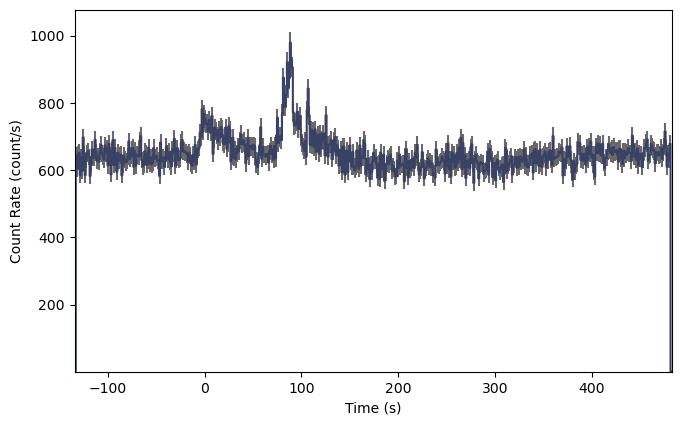

In [7]:
# # slice from -130 to 480 s
# time_sliced_tte = tte_combined.slice_time([-130.0, 480.0])
# # slice from 50 to 300 keV
# energy_time_sliced_tte = time_sliced_tte.slice_energy([50.0, 300.0])

# above slicing seems to make a bug in bkg fitting!

# bin event list by time
phaii_combined = tte_combined.to_phaii(bin_by_time, 1.024, time_ref=0.0)

# convert info. in .fit file into histogram and plot it
lc_data_tte = phaii_combined.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data_tte)

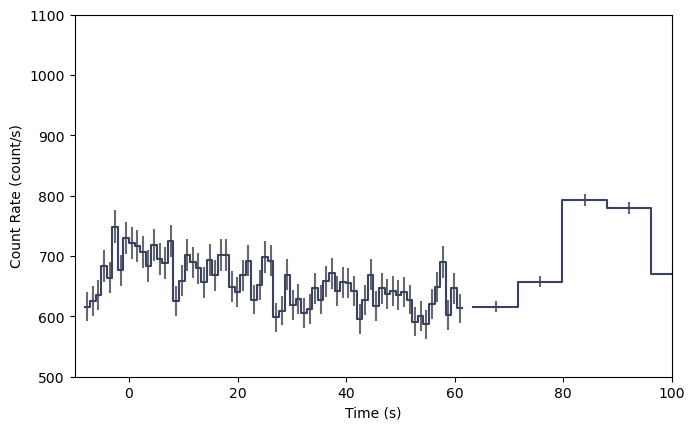

In [8]:
# zoom in to check TRIGDAT's detail
lcplot = Lightcurve(data=lc_data_trigdat)
lcplot.xlim = (-10.0, 100.0)
lcplot.ylim = (500, 1100)

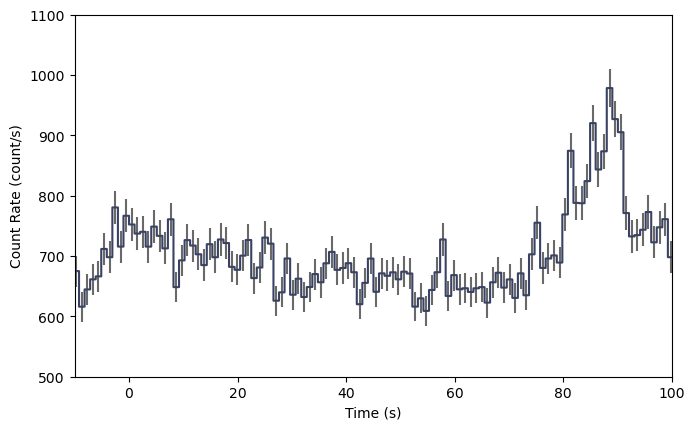

In [9]:
# zoom in to check TTE's detail
lcplot = Lightcurve(data=lc_data_tte)
lcplot.xlim = (-10.0, 100.0)
lcplot.ylim = (500, 1100)

In detail, we notice the tendency of TRIGDAT & TTE are similar, but absolute value exists some tiny differences!

In [10]:
# use eyes to define background intervals
# one before and one after the source
bkgd_times = [(-100.0, -10.0), (200.0, 400.0)]

In [11]:
# initialize background fitter with the phaii object and time ranges to fit
backfitter = BackgroundFitter.from_phaii(phaii_combined, Polynomial, time_ranges=bkgd_times)
backfitter.fit(order=1)

In [12]:
# check if it’s a good fit
backfitter.statistic/backfitter.dof

array([1.01774302, 1.0281851 , 0.97433735, 0.9731555 , 1.0229369 ,
       0.97723762, 0.92732419, 0.87566507, 0.88517187, 0.96320197,
       0.97519547, 0.95939338, 0.99971419, 0.91733545, 1.03327637,
       0.95809164, 1.12543919, 1.03540751, 0.94473132, 1.06701587,
       1.08009745, 1.03152759, 0.96139927, 0.99393022, 0.97240855,
       1.11366832, 0.90240803, 0.92863727, 0.93126623, 0.99543758,
       0.97608316, 0.92064937, 1.03433172, 1.0203094 , 0.93425994,
       0.8923496 , 1.11020442, 1.12811693, 1.01572336, 1.07889142,
       1.02545529, 0.98551502, 0.89817334, 1.04714325, 0.79915578,
       0.85530743, 1.22964189, 1.03063069, 1.13335308, 1.00588879,
       1.11520344, 0.99407245, 1.02880453, 0.91967347, 0.92905142,
       1.04974448, 0.95272819, 1.1181849 , 1.11019891, 0.90041981,
       1.11578033, 1.12238119, 0.90745523, 0.92896516, 1.07949615,
       0.89148522, 0.93781645, 0.99333539, 0.87245559, 1.0489214 ,
       0.91930264, 0.9101154 , 0.98333404, 1.07396701, 0.90567

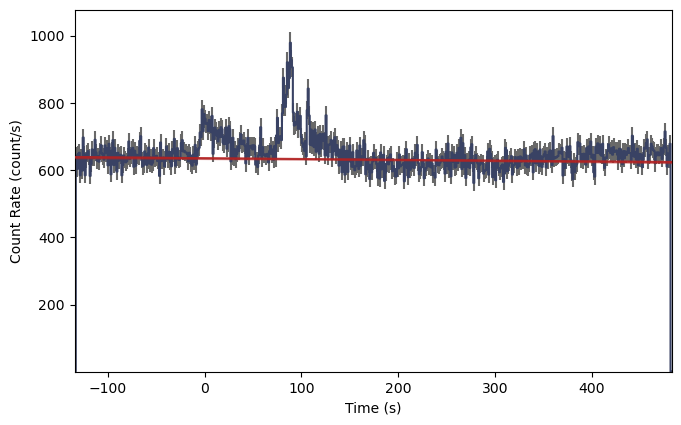

In [13]:
# interpolated over the source interval
bkgd = backfitter.interpolate_bins(phaii_combined.data.tstart, phaii_combined.data.tstop)

# convert info. in .fit file into histogram and plot it
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data_tte, background=lc_bkgd)

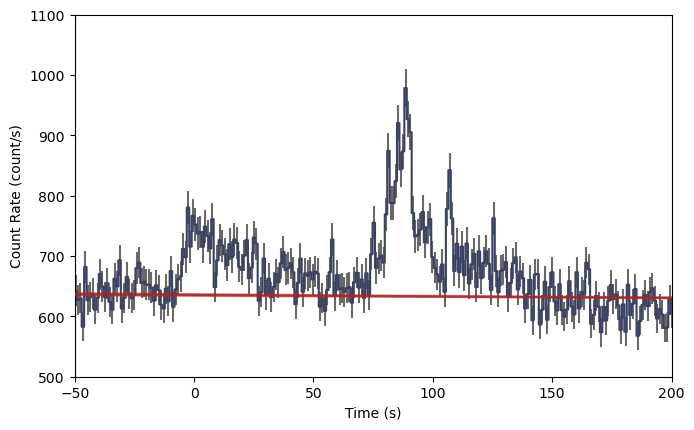

In [14]:
# zoom in to check TTE + bkg fitting
lcplot = Lightcurve(data=lc_data_tte, background=lc_bkgd)
lcplot.xlim = (-50.0, 200.0)
lcplot.ylim = (500, 1100)